In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
image_size = 224
batch_size = 8

save_model_filename = 'cassava_2.h5'

In [5]:
train = pd.read_csv('./cassava-leaf-disease-classification/train.csv')

In [6]:
train.head(10)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
5,1000837476.jpg,3
6,1000910826.jpg,2
7,1001320321.jpg,0
8,1001723730.jpg,4
9,1001742395.jpg,3


In [7]:
data = {"0":"Cassava Bacterial Blight (CBB)",
        "1":"Cassava Brown Streak Disease (CBSD)",
        "2":"Cassava Green Mottle (CGM)",
        "3":"Cassava Mosaic Disease (CMD)",
        "4":"Healthy"}

disease_label = pd.DataFrame(data=data.values(),index=data.keys(),columns=['Disease_Name'])

In [8]:
disease_label

,Disease_Name
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [9]:
train_path = './cassava-leaf-disease-classification/train_images'

In [10]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [11]:
train.head(10)

,image_id,label
0,./cassava-leaf-disease-classification/train_im...,0
1,./cassava-leaf-disease-classification/train_im...,3
2,./cassava-leaf-disease-classification/train_im...,1
3,./cassava-leaf-disease-classification/train_im...,1
4,./cassava-leaf-disease-classification/train_im...,3
5,./cassava-leaf-disease-classification/train_im...,3
6,./cassava-leaf-disease-classification/train_im...,2
7,./cassava-leaf-disease-classification/train_im...,0
8,./cassava-leaf-disease-classification/train_im...,4
9,./cassava-leaf-disease-classification/train_im...,3


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [13]:
train['label'] = train['label'].astype('str')

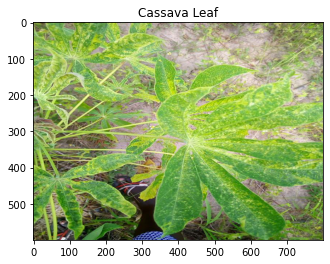

In [14]:
# display random image

index = np.random.randint(0,len(train))

plt.imshow(imread(train['image_id'][index]))
plt.title('Cassava Leaf')

plt.show()

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


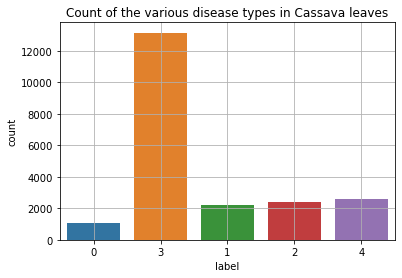

In [15]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of the various disease types in Cassava leaves')
plt.grid()
plt.show()

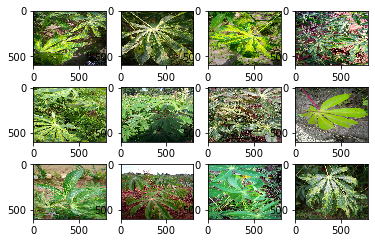

In [16]:
n_rows = 3
n_cols = 4

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        
        leaf_img = np.random.randint(0, len(train))
        img = imread(train.iloc[leaf_img]['image_id'])
        
        plt.imshow(img, cmap='binary',interpolation='nearest')

In [17]:
image_generator = ImageDataGenerator(rotation_range=15, horizontal_flip=True, vertical_flip=True,
                                     shear_range=0.2, zoom_range=0.2, brightness_range=[0.1,0.3], fill_mode='nearest', 
                                     validation_split=0.2, rescale = 1./255,
                                     preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [18]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                      subset='training', color_mode='rgb', batch_size=batch_size, seed=42,
                                                      shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.


In [19]:
validation_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', color_mode='rgb', batch_size=batch_size, seed=42,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 4279 validated image filenames belonging to 5 classes.


In [20]:
%reload_ext tensorboard

import datetime

In [21]:
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1):

    x = input_layer
    
    for cnn_num in range(num_cnn):
        shortcut = x
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal',
            padding='same', name=f'block{block_num}_conv{cnn_num}')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D( filters=channel, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal',
            padding='same', name=f'block{block_num}_1_conv{cnn_num}')(x)

        shortcut_channel = shortcut.shape.as_list()[-1]
        if shortcut_channel != channel:
            shortcut = Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(shortcut)  
        # skip connection
        x = keras.layers.Add()([x, shortcut])

    return x

In [22]:
def build_resnet(input_shape=(image_size, image_size, 3),
              num_cnn_list=[3, 4, 6, 3], channel_list=[64, 128, 256, 512], num_classes=5):
        
    input_layer = keras.layers.Input(shape=input_shape)
    
    output = input_layer
    
    output = keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding = 'same')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(output, num_cnn=num_cnn, channel=channel, block_num=i)
        
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(1000, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='softmax')(output)
    
    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    
    return model

In [23]:
model = build_resnet()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localho

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:loc

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localho

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:lo

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localh

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/repl

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy']
)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 55, 55, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [26]:
log_dir = "logs/cassava_resnet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('resnet.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

In [29]:
type(train_generator)

tensorflow.python.keras.preprocessing.image.DataFrameIterator

In [30]:
total_train = train.shape[0] * 0.8
total_val = train.shape[0] * 0.2

In [31]:
epoch = 100

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=total_val//batch_size,
    steps_per_epoch=total_train//batch_size,
    verbose=1,
    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr]
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteGraphSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSumm

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device 

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:loc

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localho

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /j

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

   1/2139 [..............................] - ETA: 0s - loss: 6.9153 - accuracy: 0.0000e+00Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
   2/2139 [..............................] - ETA: 5:49 - loss: 3325.4988 - accuracy: 0.3125WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0977s vs `on_train_batch_end` time: 0.2278s). Check your callbacks.
Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0
  40/2139 [..............................] - ETA

  84/2139 [>.............................] - ETA: 8:47 - loss: nan - accuracy: 0.0595Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 128/2139 [>.............................] - ETA: 8:38 - loss: nan - accuracy: 0.0498Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 172/2139 [=>............................] - ETA: 8:27 - loss: nan - accuracy: 0.0560Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 216/2139 [==>...........................] - ETA: 8:17 - loss: nan - accuracy: 0.0561Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 260/2139 [==>...........................] - ETA: 8:06 - loss: nan - accuracy: 0.0615Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 304/2139 [===>..........................] - ETA: 7:54 - loss: nan - accuracy: 0.0600Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 348/2139 [===>..........................] - ETA: 7:43 - loss: nan - accuracy: 0.0578Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 392/2139 [====>.........................] - ETA: 7:32 - loss: nan - accuracy: 0.0555Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 436/2139 [=====>........................] - ETA: 7:21 - loss: nan - accuracy: 0.0545Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 480/2139 [=====>........................] - ETA: 7:10 - loss: nan - accuracy: 0.0552Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 524/2139 [======>.......................] - ETA: 6:58 - loss: nan - accuracy: 0.0549Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 568/2139 [======>.......................] - ETA: 6:47 - loss: nan - accuracy: 0.0546Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 612/2139 [=======>......................] - ETA: 6:36 - loss: nan - accuracy: 0.0545Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 656/2139 [========>.....................] - ETA: 6:24 - loss: nan - accuracy: 0.0534Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 700/2139 [========>.....................] - ETA: 6:13 - loss: nan - accuracy: 0.0555Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 744/2139 [=========>....................] - ETA: 6:02 - loss: nan - accuracy: 0.0553Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 788/2139 [==========>...................] - ETA: 5:50 - loss: nan - accuracy: 0.0544Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 832/2139 [==========>...................] - ETA: 5:40 - loss: nan - accuracy: 0.0546Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 876/2139 [===========>..................] - ETA: 5:28 - loss: nan - accuracy: 0.0542Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 920/2139 [===========>..................] - ETA: 5:17 - loss: nan - accuracy: 0.0545Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


 964/2139 [============>.................] - ETA: 5:05 - loss: nan - accuracy: 0.0553Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1008/2139 [=============>................] - ETA: 4:54 - loss: nan - accuracy: 0.0554Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1052/2139 [=============>................] - ETA: 4:42 - loss: nan - accuracy: 0.0551Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1096/2139 [==============>...............] - ETA: 4:31 - loss: nan - accuracy: 0.0554Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1140/2139 [==============>...............] - ETA: 4:19 - loss: nan - accuracy: 0.0556Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1184/2139 [===============>..............] - ETA: 4:08 - loss: nan - accuracy: 0.0549Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1228/2139 [================>.............] - ETA: 3:56 - loss: nan - accuracy: 0.0544Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1272/2139 [================>.............] - ETA: 3:45 - loss: nan - accuracy: 0.0546Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1316/2139 [=================>............] - ETA: 3:34 - loss: nan - accuracy: 0.0545Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1360/2139 [==================>...........] - ETA: 3:22 - loss: nan - accuracy: 0.0542Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1404/2139 [==================>...........] - ETA: 3:11 - loss: nan - accuracy: 0.0543Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1448/2139 [===================>..........] - ETA: 2:59 - loss: nan - accuracy: 0.0547Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1492/2139 [===================>..........] - ETA: 2:48 - loss: nan - accuracy: 0.0542Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1536/2139 [====================>.........] - ETA: 2:36 - loss: nan - accuracy: 0.0540Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1580/2139 [=====================>........] - ETA: 2:25 - loss: nan - accuracy: 0.0538Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1624/2139 [=====================>........] - ETA: 2:13 - loss: nan - accuracy: 0.0536Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1668/2139 [======================>.......] - ETA: 2:02 - loss: nan - accuracy: 0.0533Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1712/2139 [=======================>......] - ETA: 1:51 - loss: nan - accuracy: 0.0540Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1756/2139 [=======================>......] - ETA: 1:39 - loss: nan - accuracy: 0.0539Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1800/2139 [========================>.....] - ETA: 1:28 - loss: nan - accuracy: 0.0537Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1844/2139 [========================>.....] - ETA: 1:16 - loss: nan - accuracy: 0.0536Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1888/2139 [=========================>....] - ETA: 1:05 - loss: nan - accuracy: 0.0533Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1932/2139 [==========================>...] - ETA: 53s - loss: nan - accuracy: 0.0529Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


1977/2139 [==========================>...] - ETA: 42s - loss: nan - accuracy: 0.0525Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


2022/2139 [===========================>..] - ETA: 30s - loss: nan - accuracy: 0.0524Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


2067/2139 [===========================>..] - ETA: 18s - loss: nan - accuracy: 0.0523Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


2112/2139 [============================>.] - ETA: 7s - loss: nan - accuracy: 0.0520Executing op __inference_train_function_5966 in device /job:localhost/replica:0/task:0/device:GPU:0


2139/2139 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0521Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Opti

Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_10916 in device /job:localhost/replica:0/task:0/device:GPU:0


InvalidArgumentError: Nan in summary histogram for: conv2d/kernel_0 [Op:WriteHistogramSummary]

In [ ]:
%tensorboard --logdir logs/cassava_resnet

In [ ]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['accuracy', 'val_accuracy']])
axs[1].set_title('Model Accuracy')

plt.show()

In [ ]:
test = pd.read_csv('./cassava-leaf-disease-classification/sample_submission.csv')

test_path = './cassava-leaf-disease-classification/test_images'
def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

In [ ]:
test.head()

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.vgg16.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

In [ ]:
output = model.predict_generator(test_generator)

In [ ]:
print(np.argmax(output))

In [ ]:
model.save(save_model_filename)